Importing Libraries

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop
from mpl_toolkits import mplot3d
from keras.utils import to_categorical
import seaborn as sns
import plotly.colors as plc
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import plotly
import time
import plotly.graph_objs as go

Load Data


In [49]:
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [50]:
print('Traning data shape:', x_train.shape)
print('Testing data shape:', x_test.shape)
print('Traning labels shape:', y_train.shape)
print('Testing labels shape:', y_test.shape)

Traning data shape: (50000, 32, 32, 3)
Testing data shape: (10000, 32, 32, 3)
Traning labels shape: (50000, 1)
Testing labels shape: (10000, 1)


In [51]:
# Find the unique numbers from the train labels
# so that we can figure out how many different outputs we have
classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


Example display of dataset

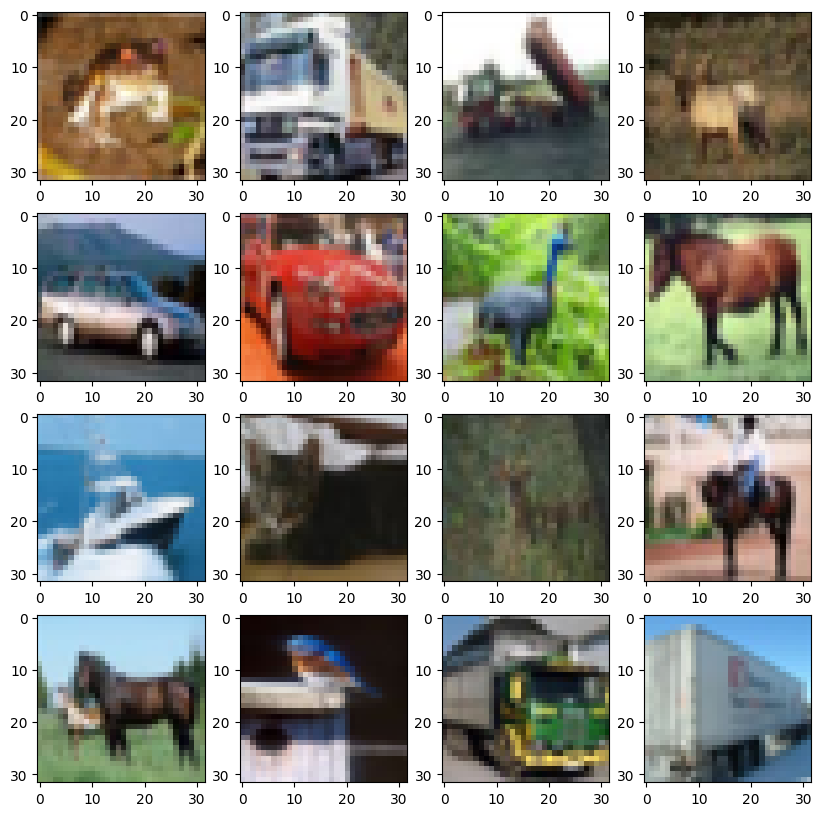

In [52]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))  # Added figsize for better visualization

for i in range(4):
    for j in range(4):
        index = i*4 + j  # Calculate the correct index for x_train
        curr_img = np.reshape(x_train[index], (32,32,3))  # Reshape the current image if necessary
        axs[i, j].imshow(curr_img)  # Display the image in the correct subplot

plt.show()  # Display the figure with all subplots


In [53]:
# Since RGB codes between 0 and 255, we can normalize it to between 0 and 1 for better performance
print(f'Before: {np.min(x_train),np.max(x_train)}')
x_train = x_train/255
print(f'After: {np.min(x_train),np.max(x_train)}')


Before: (0, 255)
After: (0.0, 1.0)


In [54]:
# For better performance we will flatten 32x32 pixel with 3 rgb color image into single np array.
x_train_flat = x_train.reshape(-1,3072)
x_test_flat = x_test.reshape(-1, 3072)
# Flattened image datas , -1 indicates auto size, 3072 = 32x32x3
# 32,32 = pixel ratio, 3 = RGB
print(x_train.shape)
print(x_train_flat.shape)

(50000, 32, 32, 3)
(50000, 3072)


In [55]:
# rename feature columns.
feat_cols = ['pixel'+str(i) for i in range(x_train_flat.shape[1])]

df_cifar = pd.DataFrame(x_train_flat,columns=feat_cols)
df_cifar['label'] = y_train


In [56]:
# Specify a function that demonstrates all required processes and returns accuracy rating

# This function trains dataset without any PCA process. 
def TRAIN_WITHOUT_PCA(X_train, X_test, y_train, y_test):
    
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    batch_size = 128
    num_classes = 10
    epochs = 20
    
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_shape=(3072,)))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile the model
    model.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(),
                metrics=['accuracy'])

    start_time = time.time()
    history = model.fit(X_train, y_train,batch_size=batch_size,epochs=epochs,verbose=1,
                        validation_data=(X_test, y_test))
    end_time = time.time()
    # Train the model
    
    training_time = end_time - start_time
    val_accuracy = history.history['val_accuracy'][-1]
    loss = history.history['loss'][-1]
    accuracy = history.history['accuracy'][-1]
    
    info = [loss,accuracy, training_time, val_accuracy]
    
    info_text = (f'[*] | ORIGINAL DATA | Test Loss: {loss:.4f} | Test Accuracy: {accuracy:.4f} | Time: {training_time:.4f} | Validation Accuracy: {val_accuracy:.4f}')
    info.append(info_text)
    return info

# Case refers to PCA component test cases. Its an object which stores all required functions and visualization processes including training.
class CASE:
    def __init__(self, dataset, num_components, labels):
        self.component_number = num_components
        self.component_count = num_components
        if type(num_components) == float :
            self.train_labels = labels[0]
            self.test_labels = labels[1]
            self.training_data = dataset[0]
            self.testing_data = dataset[1]
            
            self.X_train = None
            self.X_test = None
            self.Y_train = None
            self.Y_test = None
            
            self.information = self.calculate_information_float()        
        else:
            self.training_data = dataset
            self.labels = labels
            self.information = self.calculate_information()
        self.training_information = None
    
    # if PCA inputs are float, this will generate the train data using PCA percentage
    def calculate_information_float(self):
        pca = PCA(self.component_number)
        pca.fit(self.training_data)
        PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None, svd_solver='auto', tol=0.0, whiten=False)
        
        self.X_train = pca.transform(self.training_data)
        self.X_test = pca.transform(self.testing_data)
        self.Y_train = to_categorical(self.train_labels)
        self.Y_test = to_categorical(self.test_labels)
        self.component_count = pca.n_components_
        explained_variance_list = [[index + 1, round(value * 100, 2)] for index, value in enumerate(pca.explained_variance_ratio_)]
        total = 0
        for i,t in explained_variance_list:
            total+=t
        loss = 100-total
        explained_variance_list.append([self.component_number+1,loss])
        return explained_variance_list
    
    # if PCA inputs are integer, this will generate the train data using PCA component number    
    def calculate_information(self):
        pca = PCA(self.component_number)
        columns = []
        PCA_CIFAR = pca.fit_transform(self.training_data.iloc[:,:-1])
        for i in range(self.component_number):
            columns.append(f'PC{i+1}')
        
        self.training_data = pd.DataFrame(data = PCA_CIFAR, columns = columns)
       # self.training_data['Y'] = self.labels
        print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
        explained_variance_list = [[index + 1, round(value * 100, 2)] for index, value in enumerate(pca.explained_variance_ratio_)]
        total = 0
        for i,t in explained_variance_list:
            total+=t
        loss = 100-total
        explained_variance_list.append([self.component_number+1,loss])
        return explained_variance_list
    
    # Basic representation function
    def __repr__(self):
        output = f'\n[CASE Component Number : {self.component_number}]\n'
        output += ('Information Percentage: ')
        total = 0
        for index,comp_acc in self.information[:-1]:
            output+=(f'\nPC{index} : %{(comp_acc)}')
            total += comp_acc
        
        output+= f'\nLoss : %{(self.information[-1][1]):.2f}'
        self.loss = self.information[-1][1]
        return output
    
    # Creates a graph which represents case's explained_variance_ratio and loss percentage.
    def Graph(self):
        x = [data[0] for data in self.information]
        y = [data[1] for data in self.information]
        labels = [str(data[0]) if data[0] != x[-1] else 'loss' for data in self.information]

        colors = ['blue'] * (len(x) - 1) + ['red']
        plt.bar(x, y, color=colors)
        plt.xticks(x, labels)
        plt.yticks(y)
        plt.gca().get_xticklabels()[-1].set_color('red')
        # Eksen etiketlerini ve başlığı ekleme
        plt.xlabel('Component Number')
        plt.ylabel('Information Accuracy')

        # Grafiği gösterme
        plt.show()
    
    # Main Visualize function for case. Checks input dimension and calls corresponding method.
    def Visualize(self):
        dataframe = self.training_data
        dim = dataframe.shape[1]
        print(dataframe.shape)
        if dim > 5:
            print(f'Shape of dataframe is not supported. Only supports up to 5 dimensions. We got {dataframe.shape[1]}')
            return
        if dim == 2:
            self.V_2(dataframe)
        elif dim ==3:
            self.V_3(dataframe)
        elif dim == 4 :
            self.V_4(dataframe)
        elif dim == 5:
            self.V_5(dataframe)
    
    '''
    2 Dimension (2D) Visualization
    x = PC1 
    y = PC2
    '''
    def V_2(self, dataframe):
        labels = [label[0] for label in y_train]

        # Renk skalası seçimi
        colorscale = plc.qualitative.Light24

        markercolor = [colorscale[i % len(colorscale)] for i in labels]

        fig1 = go.Scatter(x=dataframe['PC1'],
                        y=dataframe['PC2'],
                        marker=dict(color=markercolor,
                                opacity=1,
                                colorscale='Viridis',
                                size=5),
                        mode='markers')

        #Make Plot.ly Layout
        mylayout = go.Layout(xaxis=dict(title="PC1"),
                            yaxis=dict( title="PC2"))

        #Plot and save html
        plotly.offline.plot({"data": [fig1],
                            "layout": mylayout},
                            auto_open=True,
                            filename=('CIFAR_2DPlot.html'))
    
    '''
    3 Dimension (3D) Visualization
    x = PC1 
    y = PC2 
    z = PC3
    '''
    def V_3(self,dataframe):
        labels = [label[0] for label in y_train]
        colorscale = plc.qualitative.Light24
        markercolor = [colorscale[i % len(colorscale)] for i in labels]
        print(dataframe.head())

        fig1 = go.Scatter3d(
            x=dataframe['PC1'],
            y=dataframe['PC2'],
            z=dataframe['PC3'],
            marker=dict(
                color=markercolor,
                colorscale='Blues',
                size=5),
                line=dict (width=0.02),
            mode='markers')

        mylayout = go.Layout(scene=dict(xaxis=dict( title="PC1"),
                                yaxis=dict( title="PC2"),
                                zaxis=dict(title="PC3")),)

        #Plot and save html
        plotly.offline.plot({"data": [fig1],
                            "layout": mylayout},
                            auto_open=True,
                            filename=("CIFAR_3DPlot.html"))
    
    '''
    4 Dimension (4D) Visualization
    x = PC1 
    y = PC2 
    z = PC3
    size = PC4 
    '''
    def V_4(self,dataframe):
        labels = [label[0] for label in y_train]
        colorscale = plc.qualitative.Light24
        markercolor = [colorscale[i % len(colorscale)] for i in labels]
        minimum_PC4 = dataframe['PC4'].min()
        maximum_PC4 = dataframe['PC4'].max()
        avg_PC4 = (minimum_PC4 + maximum_PC4) / 2
        markersize =  dataframe['PC4'].apply(lambda x: x+(-1*minimum_PC4)+avg_PC4)
        
        fig1 = go.Scatter3d(
            x=dataframe['PC1'],
            y=dataframe['PC2'],
            z=dataframe['PC3'],
            marker=dict(
                color=markercolor,
                colorscale='Blues',
                size=markersize),
                line=dict (width=0.02),
            mode='markers')

        mylayout = go.Layout(scene=dict(xaxis=dict( title="PC1"),
                                yaxis=dict( title="PC2"),
                                zaxis=dict(title="PC3")),)

        #Plot and save html
        plotly.offline.plot({"data": [fig1],
                            "layout": mylayout},
                            auto_open=True,
                            filename=("CIFAR_4DPlot.html"))
    
    '''
    5 Dimension (5D) Visualization
    x = PC1 
    y = PC2 
    z = PC3
    size = PC4 
    shape = PC5
    '''
    def V_5(self,dataframe):
        labels = [label[0] for label in y_train]
        colorscale = plc.qualitative.Light24
        markercolor = [colorscale[i % len(colorscale)] for i in labels]
        minimum_PC4 = dataframe['PC4'].min()
        maximum_PC4 = dataframe['PC4'].max()
        avg_PC4 = (minimum_PC4 + maximum_PC4) / 2
        markersize =  dataframe['PC4'].apply(lambda x: x+(-1*minimum_PC4)+avg_PC4)
        
        minimum = dataframe['PC5'].min()
        maximum = dataframe['PC5'].max()
        avg = (maximum + minimum)/2
        
        markershape = dataframe['PC5'].apply(lambda x: 'circle' if x < avg else 'square')

        

        fig1 = go.Scatter3d(
            x=dataframe['PC1'],
            y=dataframe['PC2'],
            z=dataframe['PC3'],
            marker=dict(
                color=markercolor,
                symbol=markershape,
                colorscale='Blues',
                size=markersize),
                line=dict (width=0.02),
            mode='markers')

        mylayout = go.Layout(scene=dict(xaxis=dict( title="PC1"),
                                yaxis=dict( title="PC2"),
                                zaxis=dict(title="PC3")),)

        #Plot and save html
        plotly.offline.plot({"data": [fig1],
                            "layout": mylayout},
                            auto_open=True,
                            filename=("CIFAR_5DPlot.html"))
    
    # Trains the current dataset which is processed by PCA.
    def TRAIN(self, TIME_WITHOUT_PCA):
        X_train = self.X_train
        X_test = self.X_test
        y_train = self.Y_train
        y_test = self.Y_test
        
        component_number = X_train.shape[1]
        
        batch_size = 128
        num_classes = 10
        epochs = 20
        
        print("X_train shape:", X_train.shape)
        print("X_test shape:", X_test.shape)

        model = Sequential()
        model.add(Dense(1024, activation='relu', input_shape=(component_number,)))
        model.add(Dense(1024, activation='relu'))
        model.add(Dense(512, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(num_classes, activation='softmax'))
        
        print(f'[MODEL OF {self.component_number}]') # refers to percentage
        model.summary()
        print()
        # Compile the model
        model.compile(loss='categorical_crossentropy',
                    optimizer=RMSprop(),
                    metrics=['accuracy'])

        start_time = time.time()
        history = model.fit(X_train, y_train,batch_size=batch_size,epochs=epochs,verbose=1,
                            validation_data=(X_test, y_test))
        end_time = time.time()
        # Train the model
        
        training_time = end_time - start_time
        loss = history.history['loss'][-1]
        accuracy = history.history['accuracy'][-1]
        
        performance = TIME_WITHOUT_PCA * (TIME_WITHOUT_PCA - training_time) / 100 

        info = [component_number, loss, accuracy, training_time, performance, self.component_count]
        
        self.training_information = info
        info_text = (f'[*] | Shape:{X_train.shape} | Component Count:  {self.component_number} | Test Loss: {loss:.4f} | Test Accuracy: {accuracy:.4f} | Time: {training_time:.4f} | Speed: {performance:.4f}%')
        info.append(info_text)
        return info
    
    # Returns training data
    def get_data(self):
        return self.training_data
        
# PCA Model which automatically generates PCA Cases based on taken inputs.        
class PCA_TEST:
    def __init__(self, dataset, labels, *args):
        self.cases = []
        self.results = []
        for component_number in args:
            new_case = CASE(dataset, component_number, labels)
            self.cases.append(new_case)
    
    # Basic representation function 
    def __repr__(self):
        output = '[TEST RESULTS]'
        for case in self.cases:
            output += f'\n{case}'
        return output
    
    # Automatically visualizes all generated cases one by one.
    def Visualize(self):
        for case in self.cases:
            case.Visualize()
    
    # Creates Bar Graph based on explained_variance_ratio to display amount of information or variance each principal component holds.
    def Information_Percentage_Graph(self):
        plt.figure(figsize=(20, 14))
        num_cases = len(self.cases)
        rows = 2
        cols = (num_cases + 1) // rows  
        for index,case in enumerate(self.cases):
            plt.subplot(rows, cols, index+1)
            x = [data[0] for data in case.information]
            y = [data[1] for data in case.information]
            labels = [str(data[0]) if data[0] != x[-1] else 'loss' for data in case.information]

            colors = ['blue'] * (len(x) - 1) + ['red']
            plt.bar(x, y, color=colors)
            plt.xticks(x, labels)
            plt.yticks(y)
            plt.gca().get_xticklabels()[-1].set_color('red')
            # Eksen etiketlerini ve başlığı ekleme
            plt.xlabel('Component Number')
            plt.ylabel('Information Accuracy')
            plt.title(f'Component Number : {case.component_number}')

            # Grafiği gösterme
        plt.show()
    
    # Creates Bar Graph based on explained_variance_ratio to illustrate what percentage of the information is lost in each case.
    def Loss_Percentage_Graph(self):
        losses = []
        for c in self.cases:
            losses.append([c.component_number, c.information[-1][1]])
        x = [data[0] for data in losses]
        y = [data[1] for data in losses]
        colors = ['red'] * len(x)
        plt.bar(x, y, color=colors)
        plt.xticks(x)
        plt.yticks(y)
        # Eksen etiketlerini ve başlığı ekleme
        plt.xlabel('Component Number')
        plt.ylabel('Loss')

        # Grafiği gösterme
        plt.show()
    
    # Creates Bar Graph based on each case's training information to illustrate loss, accuracy, training time e.g. 
    def TRAIN_GRAPH(self):
        component_number = []
        component_count  = []
        loss = []
        accuracy = []
        performance = []
        training_time = []
        for case in self.cases:
            component_number.append(case.training_information[0])
            loss.append(case.training_information[1])
            accuracy.append(case.training_information[2])
            training_time.append(case.training_information[3])
            performance.append(case.training_information[4])
            component_count.append(case.training_information[5])

        X_axis = np.arange(len(component_number))
        
        length = 0.2 
        bars1 = plt.bar(X_axis - ((3/2)*length), component_count, 0.2, label='Component Count')
        bars2 = plt.bar(X_axis - length/2, accuracy, 0.2, label='Accuracy')
        bars3 = plt.bar(X_axis + length/2, loss, 0.2, label='Loss')
        bars4 = plt.bar(X_axis + ((3/2)*length), performance, 0.2, label='Performance')

        # Her bir barın üzerine değerleri ekleyin
        for bars in [bars1, bars2, bars3, bars4]:
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, height, '%.2f' % height, ha='center', va='bottom')
        
        
        plt.xticks(X_axis, component_number) 
        plt.title("Training Analysis") 
        plt.legend() 
        plt.show() 
        
        
        
        TIME  = plt.bar(X_axis, training_time, 0.2, label='Time')

        # Her bir barın üzerine değerleri ekleyin
        for bars in [TIME]:
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, height, '%.2f' % height, ha='center', va='bottom')
        
        
        plt.xticks(X_axis, component_number) 
        plt.title("Training Analysis") 
        plt.legend() 
        plt.show() 
        
        
        
        fig, axs = plt.subplots(2, 2)
        
        axs[0, 0].plot(component_number, accuracy, 'tab:blue')
        axs[0, 0].set_title('Accuracy')
        
        axs[0, 1].plot(component_number, loss, 'tab:orange')
        axs[0, 1].set_title('Loss')
        
        axs[1, 0].plot(component_number, loss, 'tab:green')
        axs[1, 0].set_title('Loss')
        
        axs[1, 1].plot(component_number, performance, 'tab:green')
        axs[1, 1].set_title('Performance')
        
        
        plt.show()
    
    # Trains all case's one by one.
    def TRAIN(self, TIME_WITHOUT_PCA):
        results = []
        for case in self.cases:
            results.append(case.TRAIN(TIME_WITHOUT_PCA))
        self.results = results
        return results
    
    # Returns each case's training data.
    def DATA(self):
        datas = []
        for c in self.cases:
            datas.append(c.get_data())
        return datas


In [57]:
df_cifar.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel3063,pixel3064,pixel3065,pixel3066,pixel3067,pixel3068,pixel3069,pixel3070,pixel3071,label
0,0.231373,0.243137,0.247059,0.168627,0.180392,0.176471,0.196078,0.188235,0.168627,0.266667,...,0.847059,0.721569,0.549020,0.592157,0.462745,0.329412,0.482353,0.360784,0.282353,6
1,0.603922,0.694118,0.733333,0.494118,0.537255,0.533333,0.411765,0.407843,0.372549,0.400000,...,0.560784,0.521569,0.545098,0.560784,0.525490,0.556863,0.560784,0.521569,0.564706,9
2,1.000000,1.000000,1.000000,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,...,0.305882,0.333333,0.325490,0.309804,0.333333,0.325490,0.313725,0.337255,0.329412,9
3,0.109804,0.098039,0.039216,0.145098,0.133333,0.074510,0.149020,0.137255,0.078431,0.164706,...,0.211765,0.184314,0.109804,0.247059,0.219608,0.145098,0.282353,0.254902,0.180392,4
4,0.666667,0.705882,0.776471,0.658824,0.698039,0.768627,0.694118,0.725490,0.796078,0.717647,...,0.294118,0.309804,0.321569,0.278431,0.294118,0.305882,0.286275,0.301961,0.313725,1


Task 1 of Part 2 

In [58]:
model = PCA_TEST(
    df_cifar, # Training data
    y_train,
    2,
    3,
    4,
    5
    
)


Explained variation per principal component: [0.2907663  0.11253144]
Explained variation per principal component: [0.2907663  0.11253144 0.06694414]
Explained variation per principal component: [0.2907663  0.11253144 0.06694414 0.03676459]
Explained variation per principal component: [0.2907663  0.11253144 0.06694414 0.03676459 0.03608843]


In [59]:
for c in model.cases:
    print(c.information)

[[1, 29.08], [2, 11.25], [3, 59.67]]
[[1, 29.08], [2, 11.25], [3, 6.69], [4, 52.980000000000004]]
[[1, 29.08], [2, 11.25], [3, 6.69], [4, 3.68], [5, 49.300000000000004]]
[[1, 29.08], [2, 11.25], [3, 6.69], [4, 3.68], [5, 3.61], [6, 45.690000000000005]]


Task 1 of Part 1 

In [60]:
model.Visualize()

(50000, 2)
(50000, 3)
         PC1        PC2       PC3
0  -6.401018   2.729039  1.501711
1   0.829783  -0.949943  6.003754
2   7.730200 -11.522102 -2.753622
3 -10.347817   0.010738  1.101017
4  -2.625651  -4.969240  1.034586
(50000, 4)
(50000, 5)


Task 2 of Part 2 

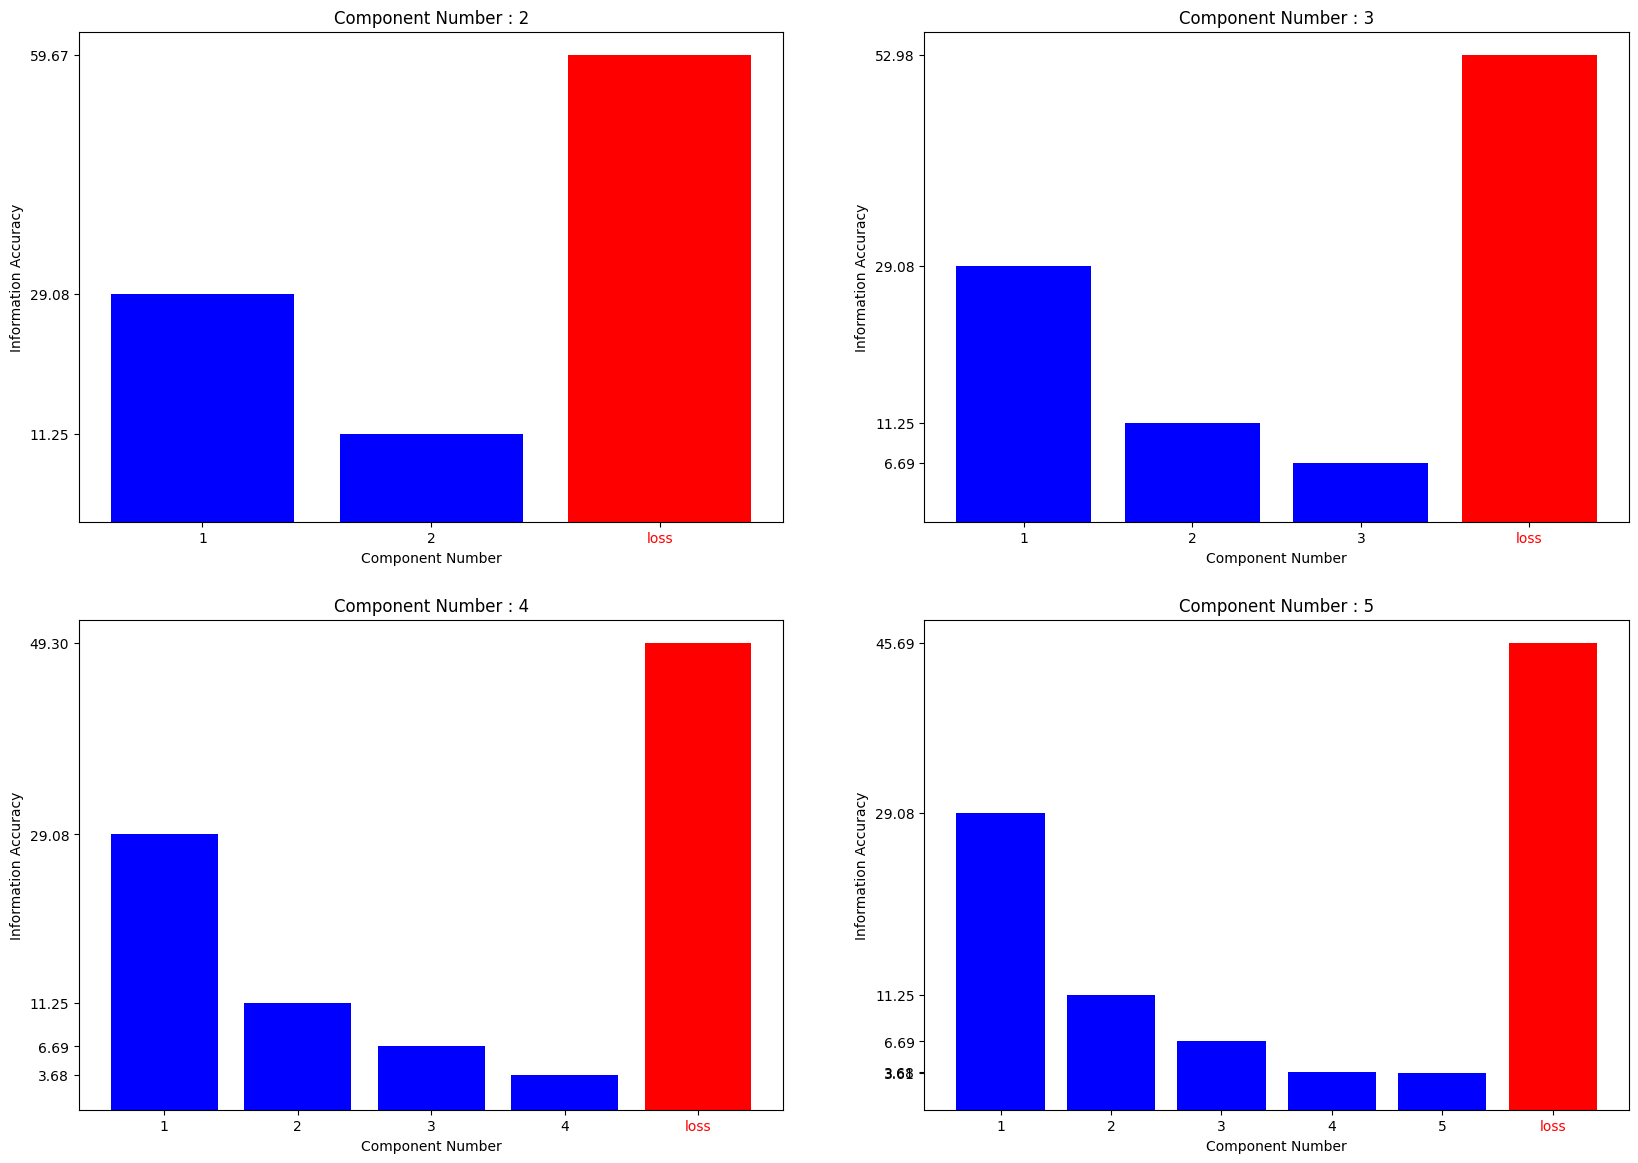

In [61]:
model.Information_Percentage_Graph()

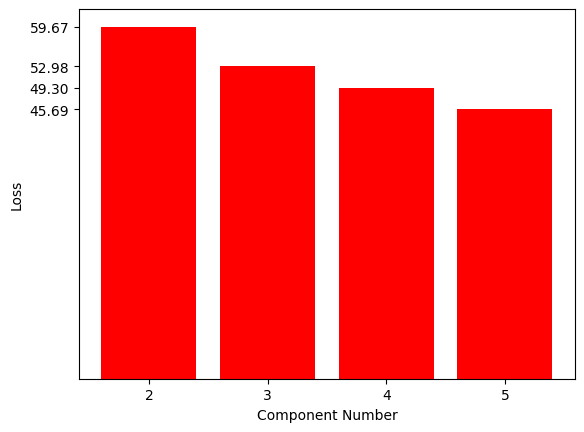

In [62]:
model.Loss_Percentage_Graph()

In [63]:
print(x_train_flat.shape)
print(x_test_flat.shape)
print(y_train.shape)
print(y_test.shape)
print(type(x_test))

print(x_train_flat[0][-1])

(50000, 3072)
(10000, 3072)
(50000, 1)
(10000, 1)
<class 'numpy.ndarray'>
0.2823529411764706


In [64]:
# Train dataset without PCA
result_without_pca = TRAIN_WITHOUT_PCA(x_train_flat, x_test_flat, y_train,y_test)
TIME_WITHOUT_PCA = result_without_pca[2]
print(result_without_pca[4])


Epoch 1/20
391/391 [==============================] - 6s 14ms/step - loss: 2.0971 - accuracy: 0.2468 - val_loss: 163.2568 - val_accuracy: 0.3387
Epoch 2/20
391/391 [==============================] - 5s 14ms/step - loss: 1.8273 - accuracy: 0.3402 - val_loss: 168.3463 - val_accuracy: 0.3475
Epoch 3/20
391/391 [==============================] - 5s 14ms/step - loss: 1.7373 - accuracy: 0.3745 - val_loss: 227.0208 - val_accuracy: 0.3280
Epoch 4/20
391/391 [==============================] - 5s 13ms/step - loss: 1.6679 - accuracy: 0.4009 - val_loss: 234.4574 - val_accuracy: 0.3460
Epoch 5/20
391/391 [==============================] - 5s 13ms/step - loss: 1.6088 - accuracy: 0.4252 - val_loss: 165.6112 - val_accuracy: 0.4008
Epoch 6/20
391/391 [==============================] - 5s 13ms/step - loss: 1.5628 - accuracy: 0.4423 - val_loss: 170.9834 - val_accuracy: 0.3852
Epoch 7/20
391/391 [==============================] - 5s 14ms/step - loss: 1.5189 - accuracy: 0.4577 - val_loss: 212.9129 - val_ac

TASK 3 OF PART 2 

In [65]:
PCA_CIFAR = PCA_TEST(
    [x_train_flat,x_test_flat],
    [y_train,y_test],
    0.9,
    0.8,
    0.7,
    0.6,
    0.5
)

# Train dataset with PCA
results = PCA_CIFAR.TRAIN(TIME_WITHOUT_PCA)
for i in results:
    print(i[4])

X_train shape: (50000, 99)
X_test shape: (10000, 99)
[MODEL OF 0.9]
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_65 (Dense)            (None, 1024)              102400    
                                                                 
 dense_66 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_67 (Dense)            (None, 512)               524800    
                                                                 
 dense_68 (Dense)            (None, 256)               131328    
                                                                 
 dense_69 (Dense)            (None, 10)                2570      
                                                                 
Total params: 1810698 (6.91 MB)
Trainable params: 1810698 (6.91 MB)
Non-trainable params: 0 (0.00 Byte)
_____________

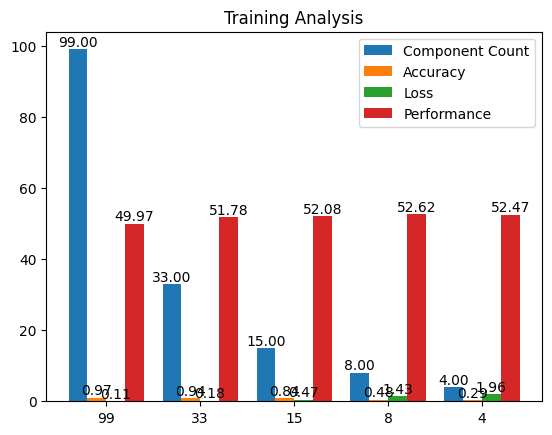

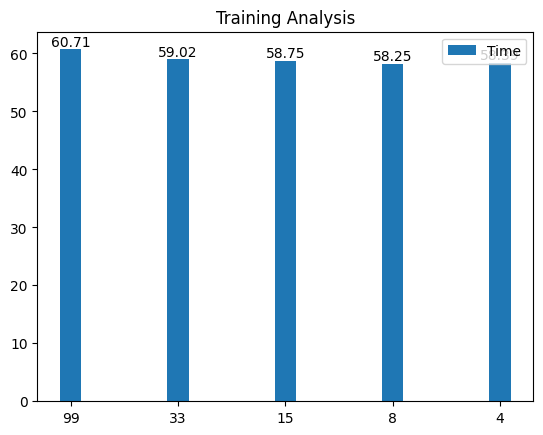

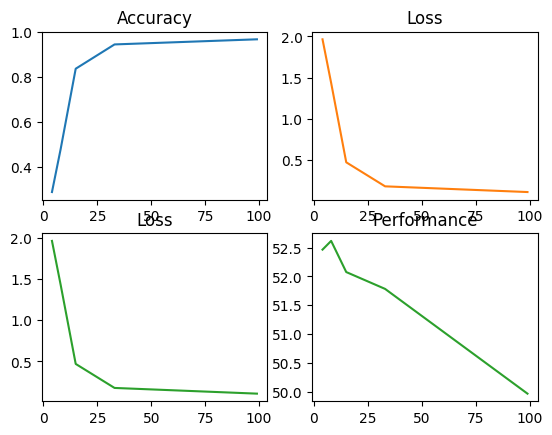

In [66]:
# Trained Dataset Graph
PCA_CIFAR.TRAIN_GRAPH()
